In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

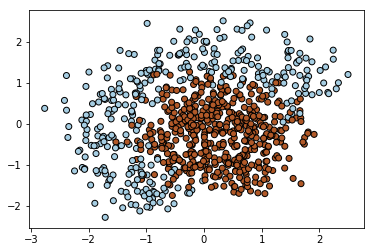

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    X_ = tf.zeros((X.shape[0], 6))
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(X.shape[0], 1))], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    out = tf.transpose(tf.sign(tf.matmul(expand(X.astype(np.float32)), w[np.newaxis].T)))
    with tf.Session() as sess:
        return out.eval()

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    loss = tf.squeeze(1 - tf.multiply(y, tf.transpose(tf.matmul(expand(X), tf.transpose(w)))), name="loss")
    out = tf.reduce_mean(tf.maximum(loss, tf.zeros(shape=loss.shape)))
    return out
    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_ = expand(X)
    loss = tf.squeeze(1 - tf.multiply(y, tf.transpose(tf.matmul(X_, tf.transpose(w)))), name="loss")
    d = tf.where(loss > 0, -X_ * tf.transpose(y), tf.zeros(X_.shape), name="d")
    out = tf.reduce_mean(d, axis=0)
    return out

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

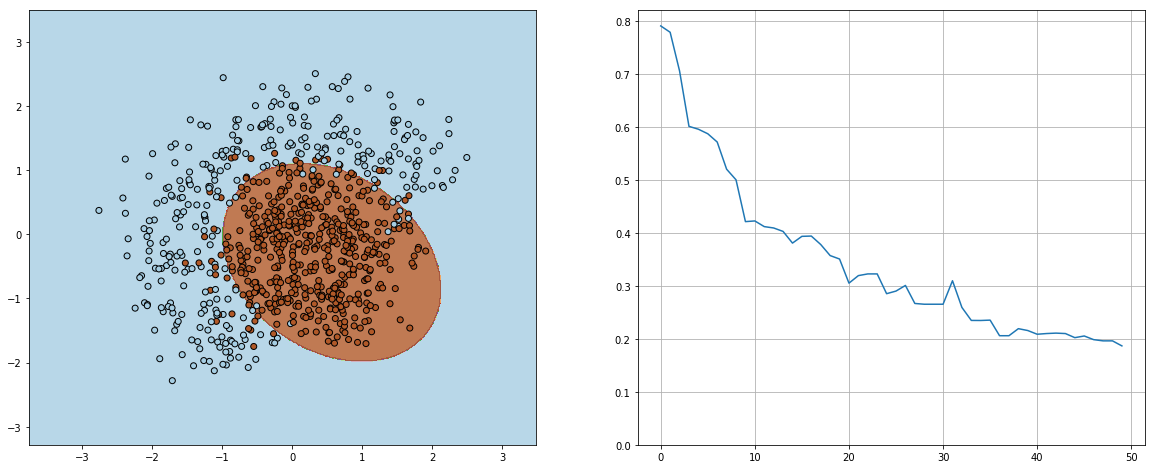

In [6]:
n_iter = 50
batch_size = 4

X_in = tf.placeholder(tf.float32, shape=X.shape, name="X_in")
y_in = tf.placeholder(tf.float32, shape=(1, X.shape[0]), name="y_in")
X_batch = tf.placeholder(tf.float32, shape=(batch_size, X.shape[1]), name="X_batch")
y_batch = tf.placeholder(tf.float32, shape=(1, batch_size), name="y_batch")

alpha = 0.25 # learning rate

w = tf.Variable([[1., 0., 0., 0., 0., 0.]], tf.float32, name = "w")

loss = compute_loss(X_in, y_in, w)
grad = compute_grad(X_batch, y_batch, w)
assign_w = tf.assign(w, w - alpha * grad)

losses = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        losses[i] = sess.run(loss, feed_dict={X_in: X, y_in: y.reshape(1, X.shape[0])})
        sess.run(assign_w, feed_dict={X_batch: X[ind, :], y_batch: y[ind].reshape(1, batch_size)})

    visualize(X, y, w.eval(sess)[0], losses, n_iter)
    plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

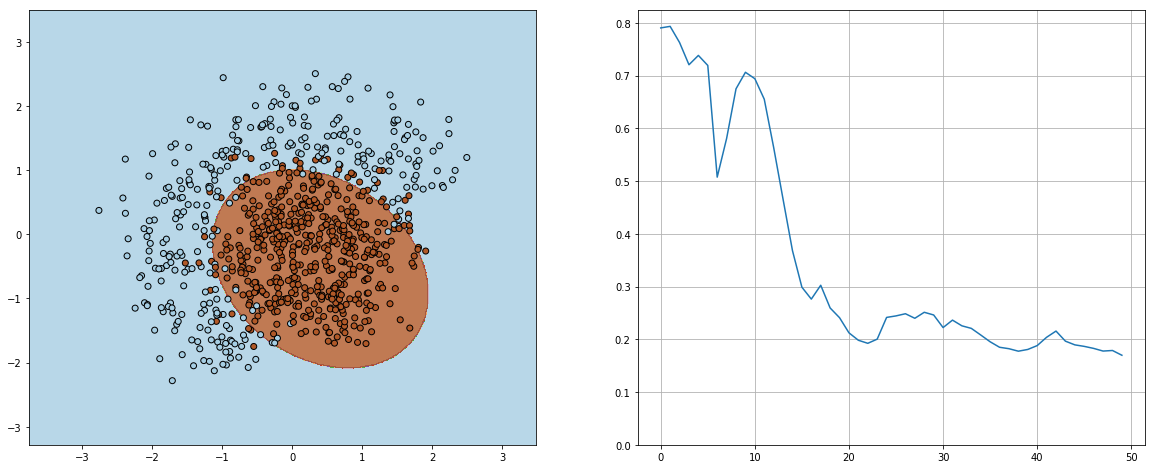

In [7]:
alpha = 0.2 # learning rate
mu = 0.5 # momentum

w = tf.Variable([[1., 0., 0., 0., 0., 0.]], tf.float32, name = "w")
v = tf.Variable([[0., 0., 0., 0., 0., 0.]], tf.float32, name = "v")

loss = compute_loss(X_in, y_in, w)
grad = compute_grad(X_batch, y_batch, w)
assign_v = tf.assign(v, mu * v - alpha * grad)
assign_w = tf.assign(w, w + assign_v)

losses = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        losses[i] = sess.run(loss, feed_dict={X_in: X, y_in: y.reshape(1, X.shape[0])})
        sess.run(assign_w, feed_dict={X_batch: X[ind, :], y_batch: y[ind].reshape(1, batch_size)})

    visualize(X, y, w.eval(sess)[0], losses, n_iter)
    plt.clf()

Same task but for Nesterov's accelerated gradient:

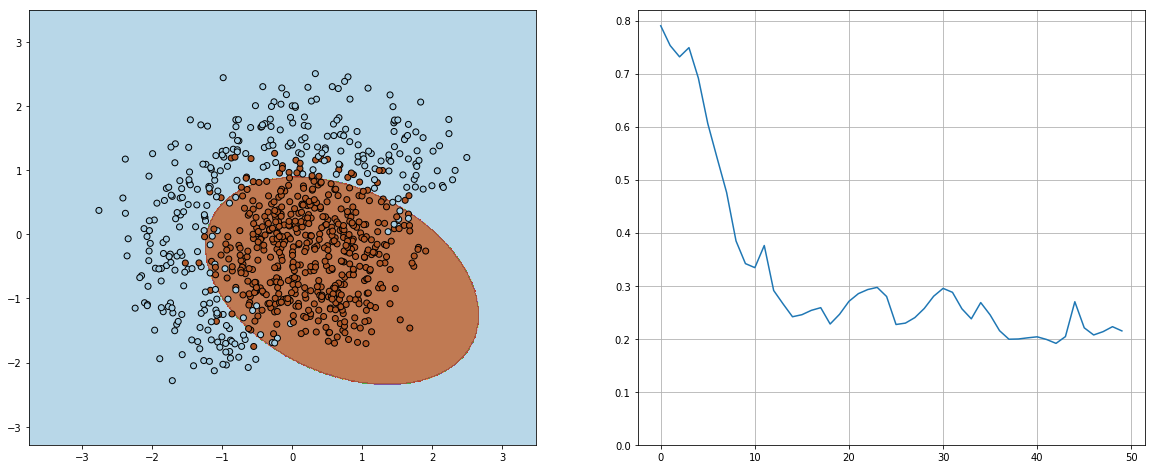

In [8]:
alpha = 0.2 # learning rate
mu = 0.5 # momentum

w = tf.Variable([[1., 0., 0., 0., 0., 0.]], tf.float32, name = "w")
v = tf.Variable([[0., 0., 0., 0., 0., 0.]], tf.float32, name = "v")

loss = compute_loss(X_in, y_in, w)
grad = compute_grad(X_batch, y_batch, w + mu * v)
assign_v = tf.assign(v, mu * v - alpha * grad)
assign_w = tf.assign(w, w + assign_v)

losses = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        losses[i] = sess.run(loss, feed_dict={X_in: X, y_in: y.reshape(1, X.shape[0])})
        sess.run(assign_w, feed_dict={X_batch: X[ind, :], y_batch: y[ind].reshape(1, batch_size)})

    visualize(X, y, w.eval(sess)[0], losses, n_iter)
    plt.clf()

Same task but for AdaGrad:

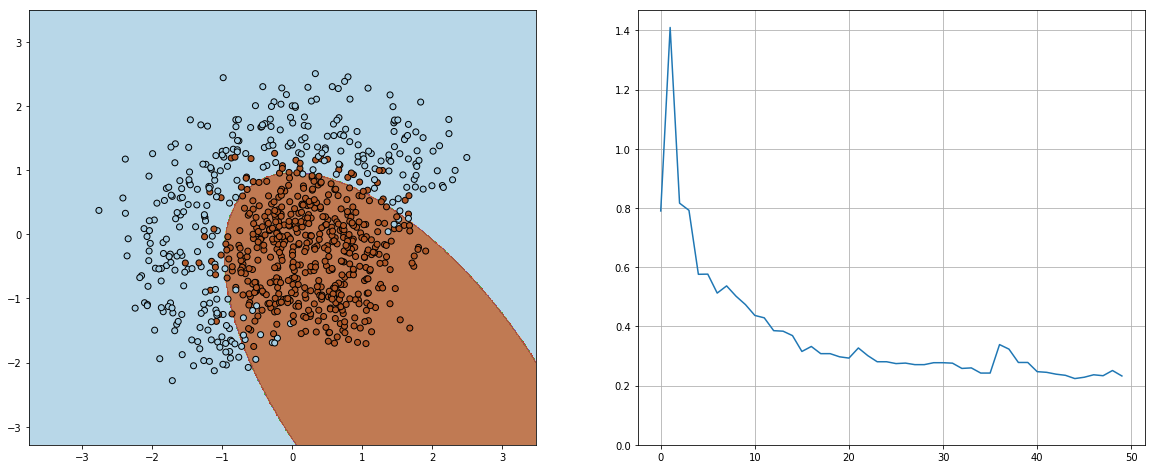

In [9]:
alpha = 0.5 # learning rate
eps = 1e-8 # A small constant for numerical stability

w = tf.Variable([[1., 0., 0., 0., 0., 0.]], tf.float32, name = "w")
c = tf.Variable([[0., 0., 0., 0., 0., 0.]], tf.float32, name = "c")

loss = compute_loss(X_in, y_in, w)
grad = compute_grad(X_batch, y_batch, w)
assign_c = tf.assign(c, c + grad ** 2)
assign_w = tf.assign(w, w - alpha / (tf.sqrt(assign_c) + eps) * grad)

losses = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        losses[i] = sess.run(loss, feed_dict={X_in: X, y_in: y.reshape(1, X.shape[0])})
        sess.run(assign_w, feed_dict={X_batch: X[ind, :], y_batch: y[ind].reshape(1, batch_size)})

    visualize(X, y, w.eval(sess)[0], losses, n_iter)
    plt.clf()

Same task but for AdaDelta:

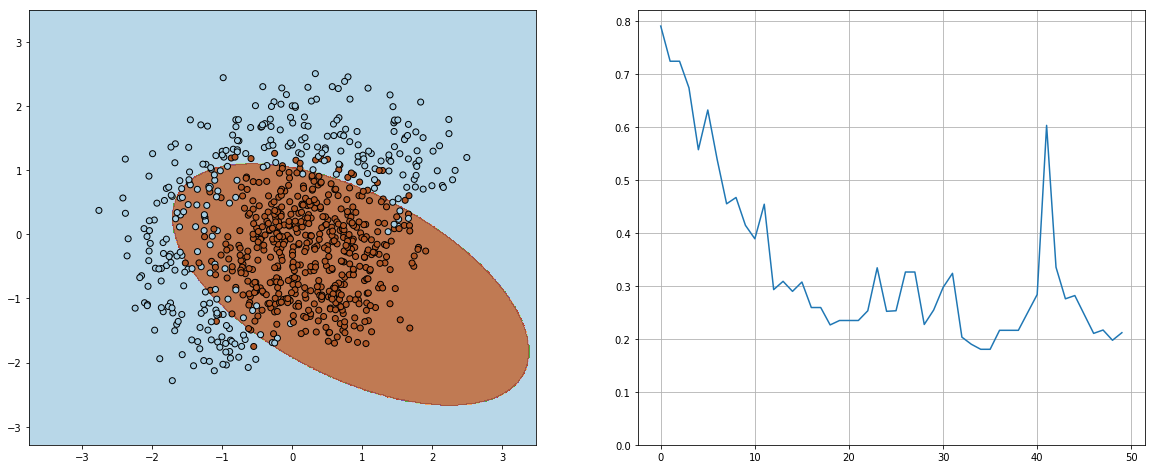

In [10]:
alpha = 0.2 # learning rate
beta = 0.5
eps = 1e-8 # A small constant for numerical stability

w = tf.Variable([[1., 0., 0., 0., 0., 0.]], tf.float32, name = "w")
c = tf.Variable([[0., 0., 0., 0., 0., 0.]], tf.float32, name = "c")

loss = compute_loss(X_in, y_in, w)
grad = compute_grad(X_batch, y_batch, w)
assign_c = tf.assign(c, beta * c + (1 - beta) * grad ** 2)
assign_w = tf.assign(w, w - alpha / (tf.sqrt(assign_c) + eps) * grad)

losses = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        losses[i] = sess.run(loss, feed_dict={X_in: X, y_in: y.reshape(1, X.shape[0])})
        sess.run(assign_w, feed_dict={X_batch: X[ind, :], y_batch: y[ind].reshape(1, batch_size)})

    visualize(X, y, w.eval(sess)[0], losses, n_iter)
    plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

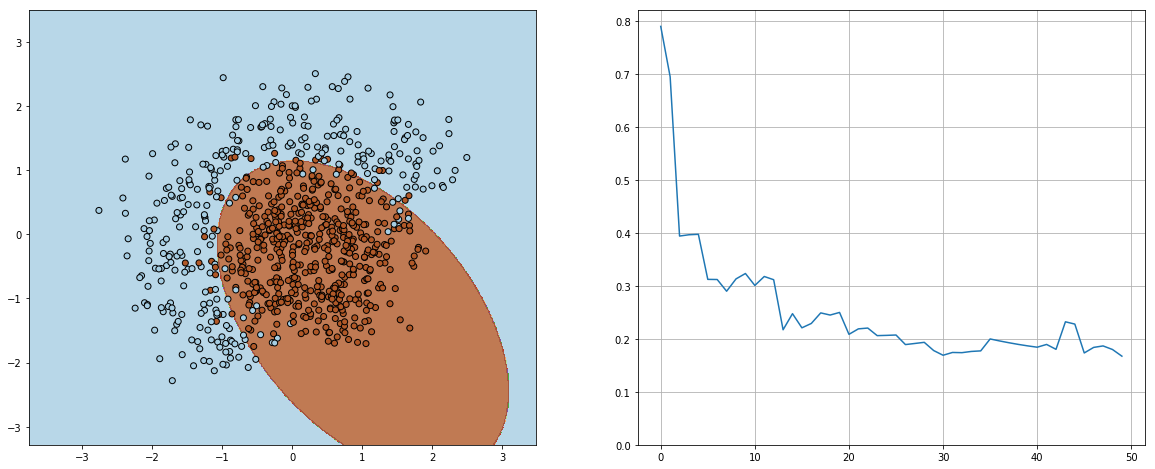

In [11]:
alpha = 0.2 # learning rate
beta = 0.9 # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu = 0.999 # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8 # A small constant for numerical stability

w = tf.Variable([[1., 0., 0., 0., 0., 0.]], tf.float32, name = "w")
c = tf.Variable([[0., 0., 0., 0., 0., 0.]], tf.float32, name = "c")
v = tf.Variable([[0., 0., 0., 0., 0., 0.]], tf.float32, name = "v")

loss = compute_loss(X_in, y_in, w)
grad = compute_grad(X_batch, y_batch, w)
assign_v = tf.assign(v, beta * c + (1 - beta) * grad)
assign_c = tf.assign(c, mu * c + (1 - mu) * (grad ** 2))
assign_w = tf.assign(w, w - alpha / (tf.sqrt(assign_c) + eps) * assign_v)

losses = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        losses[i] = sess.run(loss, feed_dict={X_in: X, y_in: y.reshape(1, X.shape[0])})
        sess.run(assign_w, feed_dict={X_batch: X[ind, :], y_batch: y[ind].reshape(1, batch_size)})

    visualize(X, y, w.eval(sess)[0], losses, n_iter)
    plt.clf()